In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (8, 3)}, font_scale=1)

# df = pd.read_csv('ECH_2019.csv')

df = pd.read_csv('/content/drive/MyDrive/ECH_2019.csv')

In [3]:
df = df.drop(columns=['nper', 'id_hogar', 'hijos', 'hijos en hogar', 'hijos en otro hogar', 'hijos en el extranjero'], axis='columns')

In [4]:
no_data = {0: 'No hay dato', '0': 'No hay dato'}

mask = df.columns.difference(['edad',
                              'sueldo',
                              'hijos en hogar',
                              'hijos en otro hogar',
                              'hijos en el extranjero',
                              'suma_hijos',
                              'barrio'])

df[mask] = df[mask].replace(no_data)

In [5]:
df['barrio'] = df['barrio'].astype('category')

df['barrio'] = df['barrio']

### AJUSTANDO DATOS PARA ENTRENAR EL MODELO

Seleccionamos personas con edad suficiente para trabajar

In [6]:
df = df[~df['estado_laboral'].str.contains('Menores de 14 años')]

df['rango_edades'] = pd.qcut(df['edad'], q=10)

df['rango_edades'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(25.0, 33.0]      10030
(13.999, 19.0]     9476
(33.0, 40.0]       9417
(52.0, 59.0]       9412
(59.0, 66.0]       9162
(74.0, 98.0]       8917
(40.0, 46.0]       8542
(19.0, 25.0]       8504
(66.0, 74.0]       8199
(46.0, 52.0]       8148
Name: rango_edades, dtype: int64

In [7]:
df['suma_hijos'] = pd.qcut(df['suma_hijos'], q=10, duplicates='drop')

df['suma_hijos'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(-0.001, 1.0]    64506
(1.0, 2.0]       12488
(2.0, 3.0]        6625
(3.0, 21.0]       6188
Name: suma_hijos, dtype: int64

In [8]:
df['estado_laboral'].value_counts()

Ocupados                                      49036
Inactivo: jubilado                            16025
Inactivo: estudiante                           8216
Inactivo: realiza los quehaceres del hogar     5936
Inactivo: pensionista                          4438
Desocupados propiamente dichos                 3409
Inactivo: otro                                 1291
Desocupados buscan trabajo por primera vez      787
Inactivo: rentista                              414
Desocupados en seguro de paro                   255
Name: estado_laboral, dtype: int64

In [9]:
df.groupby(by='estado_laboral').mean()

,edad,sueldo
estado_laboral,,
Desocupados buscan trabajo por primera vez,20.670902,25.031766
Desocupados en seguro de paro,39.074510,3602.415686
Desocupados propiamente dichos,33.915518,1559.024641
Inactivo: estudiante,17.345180,93.646543
Inactivo: jubilado,72.800936,123.482059
Inactivo: otro,33.783114,618.094500
Inactivo: pensionista,64.425192,22.757999
Inactivo: realiza los quehaceres del hogar,46.889319,317.843666
Inactivo: rentista,58.461353,72.463768


In [10]:
df = df[df['estado_laboral'].str.contains('Ocupados')]

In [11]:
salario_minimo = 17930
salario_maximo = df['sueldo'].max()

df = df[df['sueldo'] > salario_minimo]

In [12]:
df[df['estado_laboral'].str.contains('Ocupados')].groupby(by='estado_laboral').describe().transpose().loc['sueldo']

estado_laboral,Ocupados
count,24368.000000
mean,36198.103168
std,24247.487508
min,17950.000000
25%,23000.000000
50%,30000.000000
75%,40000.000000
max,900000.000000


In [13]:
quantil_99 = df["sueldo"].quantile(0.99)

df = df[df["sueldo"] < quantil_99]

quartil_1 = df["sueldo"].quantile(0.25)
quartil_3 = df["sueldo"].quantile(0.75)

iqr = quartil_3 - quartil_1

df = df[df["sueldo"] > quartil_1 - (1.5 * iqr)]

df = df[df["sueldo"] < quartil_3 + (1.5 * iqr)]

In [14]:
df['sueldo'].max()

65400

In [15]:
# df['rango_sueldos'] = pd.qcut(df['sueldo'], q=5, duplicates='drop')
df['rango_sueldos'] = pd.cut(df['sueldo'], bins=[salario_minimo, 25000, 35000, 45000, 55000, salario_maximo])

df['rango_sueldos'].value_counts()

(17930, 25000]     9042
(25000, 35000]     7138
(35000, 45000]     3744
(45000, 55000]     1732
(55000, 900000]     984
Name: rango_sueldos, dtype: int64

In [16]:
df = df.drop(['sueldo', 'edad'], axis='columns')

In [17]:
df['rango_sueldos'] = df['rango_sueldos'].cat.codes

df['rango_edades'] = df['rango_edades'].cat.codes

In [18]:
df = df.reset_index(drop=True)

In [19]:
df.sample(3)

,sexo,ascendencia,parentesco,estado_laboral,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof,barrio,estado_civil,leer_escribir,region,vivienda,estrato,suma_hijos,rango_edades,rango_sueldos
4427,Hombre,Blanca,Esposo/a o compañero/a,Ocupados,No,Construcción de obras de arquitectura,Sí,"Sí, asistió","Sí, asistió","Sí, asistió","Sí, asistió",No hay dato,No hay dato,No hay dato,No hay dato,20,Separado/a de unión libre anterior,Sí,Montevideo,Propietario solamente de la vivienda y ya la pagó,Montevideo Bajo,"(-0.001, 1.0]",4,0
10316,Mujer,Blanca,Jefe/a de hogar,Ocupados,No,Elaboración de productos de tabaco,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,8,No hay dato,Sí,Montevideo,Propietario de la vivienda y el terreno y los ...,Montevideo Medio Alto,"(1.0, 2.0]",2,3
11713,Mujer,Blanca,Jefe/a de hogar,Ocupados,No,Actividades de hospitales,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,11,Divorciado/a,Sí,Montevideo,Inquilino o arrendatario de la vivienda,Montevideo Medio Alto,"(1.0, 2.0]",5,2


In [20]:
df.to_csv('new_df.csv')

### DEFINIMOS LAS VARIABLES DEPENDIENTES E INDEPENDIENTES

In [21]:
# Feautures
X = df.drop('rango_sueldos', axis=1).to_numpy()
y = df['rango_sueldos']

print('X shape', X.shape, '\nY shape', y.shape)

X shape (22640, 23) 
Y shape (22640,)


In [22]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

X = one_hot.fit_transform(X)

In [23]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

X = normalizer.fit_transform(X)

In [24]:
X.shape

(22640, 534)

## Dejamos una fila afuera para testear el modelo más adelante

In [25]:
test_sample = X[0]
test_result = y[0]

X = X[1:]
y = y[1:]

### Dividimos los datos en un 30% de test y 70% de entrenamiento

In [26]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15847, 534) (15847,)
(6792, 534) (6792,)


# APLICAMOS EL MODELO LIGHTGBM

In [28]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [29]:
#Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_pred, y_test)

print(f'LightGBM Model accuracy score: {accuracy_score(y_test, y_pred)}')

LightGBM Model accuracy score: 0.47835689045936397


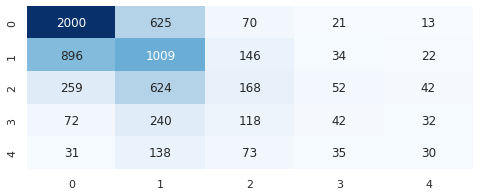

In [30]:
from sklearn.metrics import confusion_matrix

# Matriz de Confusion
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

In [31]:
print(clf.predict(test_sample))
print(test_result)

[0]
1


# REPETIMOS CON UN MODELO DE REGRESIÓN LOGISTICA

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistic_reg = LogisticRegression(multi_class='multinomial',max_iter=20000)

In [33]:
#Definicion de Hyperparámetros
param_grid = {'solver':['lbfgs', 'saga'],
              'penalty': ['l1', 'l2'], 
              'C':[10, 1.0, 0.1]}

Realizamos un random search para elegir los mejores parámetros

In [34]:
from sklearn.model_selection import RandomizedSearchCV

#Aplicamos la búsqueda al modelo
model = RandomizedSearchCV(logistic_reg, param_grid,n_iter=100, random_state=0, cv=5,scoring='accuracy',verbose=20)

In [35]:
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START C=10, penalty=l1, solver=lbfgs.............................
[CV 1/5; 1/12] END C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 1/12] START C=10, penalty=l1, solver=lbfgs.............................
[CV 2/5; 1/12] END C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 1/12] START C=10, penalty=l1, solver=lbfgs.............................
[CV 3/5; 1/12] END C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 1/12] START C=10, penalty=l1, solver=lbfgs.............................
[CV 4/5; 1/12] END C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 1/12] START C=10, penalty=l1, solver=lbfgs.............................
[CV 5/5; 1/12] END C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 2/12] START C=10, penalty=l1, solver=saga..............................
[CV 1/5; 2/12] END C=10, penalty=l1, solver=saga

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=20000,
                                                multi_class='multinomial'),
                   n_iter=100,
                   param_distributions={'C': [10, 1.0, 0.1],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=0, scoring='accuracy', verbose=20)

In [36]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'solver': 'saga', 'penalty': 'l1', 'C': 1.0}
Mejor Score: 0.4843816825656274



In [37]:
# Prediccion
prediction = model.predict(X_test)

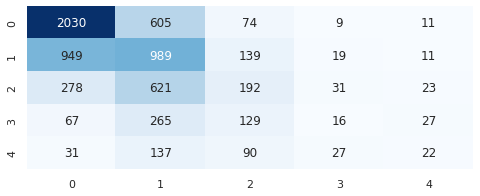

In [38]:
from sklearn.metrics import confusion_matrix

# Matriz de Confusion
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

In [39]:
print(model.predict(test_sample))
print(test_result)

[0]
1


# REPETIMOS CON UN RANDOM FOREST

In [40]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(100)

random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
scores = cross_val_score(random_forest, X, y, cv=5)

scores

array([0.46775618, 0.45693463, 0.45362191, 0.46157244, 0.4546057 ])

In [42]:
print('Promedio de cross_validation ', round(scores.mean(),2))

print('Score en train ', round(random_forest.score(X_train, y_train),2))
print('Score en test ', round(random_forest.score(X_test, y_test),2))

Promedio de cross_validation  0.46
Score en train  1.0
Score en test  0.46


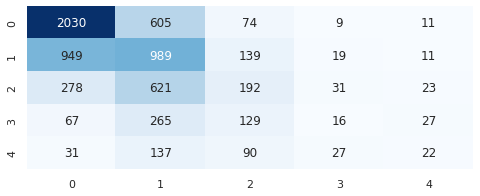

In [43]:
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

In [44]:
#Prediccion en Train
y_train_pred = random_forest.predict(X_train)

#Prediccion en Test
y_test_pred = random_forest.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Aciertos sobre entrenamiento:', round(train_accuracy, 2))
print('Aciertos sobre evaluación:', round(test_accuracy, 2))

Aciertos sobre entrenamiento: 1.0
Aciertos sobre evaluación: 0.46


In [45]:
print(random_forest.predict(test_sample))
print(test_result)

[1]
1


In [46]:
probabilidades_prediccion = random_forest.predict_proba(test_sample)
probabilidades_prediccion

array([[0.3 , 0.37, 0.12, 0.14, 0.07]])

# REPETIMOS CON UN MODELO DE K NEAREST NEIGHBOURS

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knearest_model = KNeighborsClassifier(n_neighbors=4)

knearest_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [48]:
scores = cross_val_score(knearest_model, X, y, cv=5)

scores           

array([0.41254417, 0.41033569, 0.39774735, 0.42336572, 0.41815772])

In [49]:
print('Promedio de cross_validation ', round(scores.mean(),2))
print('Score en test ', round(knearest_model.score(X_test, y_test),2))
print('Score en train ', round(knearest_model.score(X_train, y_train),2))

Promedio de cross_validation  0.41
Score en test  0.41
Score en train  0.62


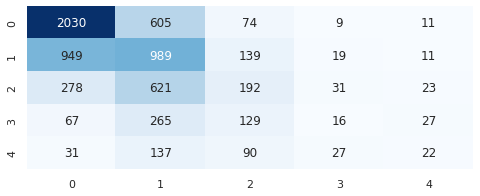

In [50]:
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

In [51]:
#Prediccion en Train
y_train_pred = knearest_model.predict(X_train)

#Prediccion en Test
y_test_pred = knearest_model.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Aciertos sobre entrenamiento:', round(train_accuracy, 2))
print('Aciertos sobre evaluación:', round(test_accuracy, 2))

Aciertos sobre entrenamiento: 0.62
Aciertos sobre evaluación: 0.41


In [52]:
print(knearest_model.predict(test_sample))
print(test_result)

[1]
1


In [53]:
probabilidades_prediccion = knearest_model.predict_proba(test_sample)
probabilidades_prediccion

array([[0.25, 0.5 , 0.  , 0.  , 0.25]])